# 1. Player Performance Quatification

---

### Importing Required Libraries

In [1]:
import numpy as np                                           # linear algebra
import pandas as pd                                          # data processing, CSV file I/O
import matplotlib.pyplot as plt                              # Data Visualization 
import seaborn as sns                                        # Python library for Visualization
from sklearn import preprocessing                            # Library for data pre-processing
from sklearn.model_selection import train_test_split         # To split dataset into training and testing
from sklearn.cluster import KMeans                           # K-Means clustering model
from sklearn.neighbors import KNeighborsClassifier           # KNN-Classification model
from sklearn.metrics import accuracy_score                   # Library to calculate accuracy of a model

max = 9223372036854775807


### Defining Functions To Evaluate Batting Performance


In [2]:
# defining calculation functions

def calcBA(pruns, pinnings, pnotout):
    ba = pruns / (pinnings - pnotout)
    return ba


def calcBS(pruns, pbfaced):
    bs = pruns / pbfaced
    return bs


def calcMRA(pinnings, pnotout, pbfaced):
    mra = (pinnings - pnotout) / pbfaced
    return mra


def calcBRPI(pfours, psixes, pinnings):
    brpi = (4*pfours + 6*psixes) / pinnings
    return brpi


def calcBatOutRate(pinnings, pnotout, pbfaced):
    outrate = pd.Series(np.array([max])) if float(pbfaced) == 0 else (pinnings - pnotout) / pbfaced
    return outrate

def calcGenBatAvg(truns, twickets):
    return truns / twickets


def calcGenBatOutRate(twickets, tbfaced):
    return twickets / tbfaced


def calcGenStrikeRate(truns, tbfaced):
    return truns / tbfaced


def calcBatAGR(tpRuns, tpBallfaced, tpOutRate, gBatAvg, gStrikeRate, gOutRate):
    agr = ((tpRuns - gStrikeRate * tpBallfaced) + gBatAvg * tpBallfaced * (gOutRate - tpOutRate))
    return agr


def calcBatRankingIndex(agr, gBatAvg):
    return agr / (10 * gBatAvg)



### Defining Functions To Evaluate Bowling Performance

In [3]:

def calcBowlAvg(runsGiven, wicketsTaken):
    return runsGiven / wicketsTaken


def calcBowlSR(ballsBowled, wicketsTaken):
    return ballsBowled / wicketsTaken


def calcBowlER(runsGiven, oversBowled):
    return runsGiven / oversBowled


def calcBowlOutRate(wicketsTaken, ballsBowled):
    outr = pd.Series(np.array([0])) if float(ballsBowled) == 0 else wicketsTaken / ballsBowled
    return outr


def calcBowlAGR(tpRunsGiven, tpOvers, tpOutrate, gBowlAvg, gBowlSR, gBowlOutrate ):
    balls = int(tpOvers) * 6 + 10 * (tpOvers - int(tpOvers))
    bowlagr = (gBowlSR * balls - tpRunsGiven) + gBowlAvg * balls * (tpOutrate - gBowlOutrate)
    
#     print(bowlagr[0])
#     if tpOvers[0] == 0.1:
#         print('-------------------------------')
#         print('tpRunsGiven  :',tpRunsGiven[0]) 
#         print('tpballs      :', balls[0])
#         print('tpOutrate    :', tpOutrate[0])
#         print('gBowlAvg     :', gBowlAvg[0]) 
#         print('gBowlSR      :', gBowlSR[0])
#         print('gBowlOutrate :',  gBowlOutrate[0])
#         print('-------------------------------')
#         print('bowlAGR      : ', bowlagr)
        
    return bowlagr


def calcBowlRI(bowlAGR, gBowlAvg):
    bri = bowlAGR / (10 * gBowlAvg)
    
#     if bri[0] == 0:
#         print('-------------------------------')
#         print('bowlagr  : ', bowlAGR[0] )
#         print('gbowlAvg : ', gBowlAvg[0])
#         print('-------------------------------')
    
    return bowlAGR / (10 * gBowlAvg)

### Defining Functions To Calculate Generic Tournament Parameters

In [4]:
# generic tournament parameters

def calcGenBowlAvg(totalRunsGiven, totalWicketsTaken):
    return totalRunsGiven / totalWicketsTaken


def calcGenBowlOutRate(totalWicketsTaken, totalOvers):
    balls = int(totalOvers) * 6 + 10 * (totalOvers - int(totalOvers))
    return totalWicketsTaken / balls


def calcGenBowlSR(totalRunsGiven, totalOvers):
    balls = int(totalOvers) * 6 + 10 * (totalOvers - int(totalOvers))
    return  totalRunsGiven / balls



### Defining Function To Claculate Series-wise Batting and Bowling Indexes for All Players 

In [5]:
def calcIndexes(srec):

    series = list(dict.fromkeys(srec["series_code"]).keys())

    # trecord : dataframe for tournament overall performance
    # precord : dataframe for player specific performance in tournament
    # tplayer: dataframe for recording total runs, ballfaced etc for player

    trecord = pd.DataFrame()
    precord = pd.DataFrame()
    tplayer = pd.DataFrame()
    pindexes = pd.DataFrame()

    tournamentPerformance = dict()

    for sr in series[:]:
        tdf = srec[srec["series_code"] == sr]

        ttotal = tdf.drop(['series_code', 'match_code', 'pid', 'name'], axis = 1)

        ttotal = pd.DataFrame(ttotal.sum(axis = 0))
        
        ttballfaced      = ttotal.at['ballfaced', 0]
        ttnotout         = ttotal.at['ballfaced', 0]
        ttruns           = ttotal.at['runs', 0]
        ttwickets_taken  = ttotal.at['wickets_taken', 0]
        ttruns_given     = ttotal.at['runs_given', 0]
        ttovers          = ttotal.at['overs', 0]

        gBatAvg = calcGenBatAvg(ttruns, ttwickets_taken)
        gBatOutRate = calcGenBatOutRate(ttwickets_taken, ttballfaced)
        gStrikeRate = calcGenStrikeRate(ttruns, ttballfaced)

        gBowlAvg = calcBowlAvg(ttruns_given, ttwickets_taken)
        gBowlOutrate = calcGenBowlOutRate(ttwickets_taken, ttovers)
        gBowlSR = calcGenBowlSR(ttruns_given, ttovers)

        players = list()
        for pl in set(tdf["pid"]):
            if pl > 0:
                players.append(pl)

        for player in players[:]:


            ptdf = tdf[tdf['pid'] == player].drop(['series_code', 'match_code', 'pid', 'name'], axis = 1)

            btinnings = np.count_nonzero(ptdf['ballfaced']);
            bwinnings = np.count_nonzero(ptdf['overs']);

            p = pd.DataFrame(ptdf.sum(axis = 0))
    
            pballfaced      = p.at['ballfaced', 0]
            pnotout         = p.at['notout', 0]
            pruns           = p.at['runs', 0]
            pwickets_taken  = p.at['wickets_taken', 0]
            pruns_given     = p.at['runs_given', 0]
            povers          = p.at['overs', 0]
            
            
            if btinnings != 0:

                batOutRate = calcBatOutRate(btinnings, pnotout, pballfaced)
                batAGR = calcBatAGR(pruns, pballfaced, batOutRate, gBatAvg, gStrikeRate, gBatOutRate)
                batRI = calcBatRankingIndex(batAGR, gBatAvg)
                
            else:
                batOutRate = batAGR = batRI = None
                
            if bwinnings != 0:
                
                bowlOutRate = calcBowlOutRate(pwickets_taken, povers)
                bowlAGR = calcBowlAGR(pruns_given, povers, bowlOutRate, gBowlAvg, gBowlSR, gBowlOutrate)
                bowlRI = calcBowlRI(bowlAGR, gBowlAvg)
                
            else:
                bowlOutRate = bowlAGR = bowlRI = None
            
            pRI = {
                'series_code' : sr,
                'pid'    : player,
                'batRI'  : batRI,
                'bowlRI' : bowlRI
            }

            pindexes = pindexes.append(pRI, ignore_index = True)
    return pindexes


### Defining Function To Claculate **Average** of Series-wise Batting and Bowling Indexes for All Players 

In [6]:
def calcAvgRI(data):
    rdata = pd.DataFrame()
    for player in set(data.pid):
        p= data[data['pid'] == player]
        ser = len(p)
        p = p.drop(['pid', 'series_code'], axis = 1 )
        p = pd.DataFrame(p.mean(axis = 0))
        p = p.swapaxes('index', 'columns')

        p.insert(0, 'pid', player)
        p.insert(0, 'series_played', ser)
        rdata = rdata.append(p)
        rdata = rdata.reset_index(drop = True)
    return rdata

### Defining function to return top n batting and bowling indexes

In [7]:
def getMaxIndexes(idata, n):
    ret = pd.DataFrame()
    
    tmp = idata.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    ret['MaxBatRI'] = tmp['batRI']
    
    tmp = idata.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    ret['MaxBowlRI'] = tmp['bowlRI']
    
    return ret.head(n)


def getMinIndexes(idata, n):
    ret = pd.DataFrame()
    
    tmp = idata.sort_values(['batRI']).reset_index(drop=True)
    ret['MinBatRI'] = tmp['batRI']
    
    tmp = idata.sort_values(['bowlRI']).reset_index(drop=True)
    ret['MinBowlRI'] = tmp['bowlRI']
    
    return ret.head(n)

### Defining functions to get min allowed indexes

In [8]:
def getMinAllowedBatRI(pindx, cons):
    minVals = getMinIndexes(pindx, 1)
    minBatRI = minVals['MinBatRI'].at[0] - cons
    return minBatRI


def getMinAllowedBowlRI(pindx, cons):
    minVals = getMinIndexes(pindx, 1)
    minBowlRI = minVals['MinBowlRI'].at[0] - cons
    return minBowlRI

*******

## 1.1 RI Calculation For International Team Players

### Imporing player record from csv file

In [9]:
imrec = pd.read_csv("serieswiseMatchRecord.csv")
imrec.head(5)

,series_code,match_code,pcid,pcountry,pid,name,notout,runs,ballfaced,fours,sixes,overs,maiden_overs,runs_given,wickets_taken
0,191,1892,7,Pakistan,-7,Extras,0,11,0,0,0,0.0,0,0,0
1,191,1892,7,Pakistan,29,Wasim Akram,1,13,24,1,0,8.3,0,46,1
2,191,1892,7,Pakistan,986,Rashid Latif,0,47,58,4,0,0.0,0,0,0
3,191,1892,7,Pakistan,1794,Inzamam-ul-Haq,0,1,20,0,0,0.0,0,0,0
4,191,1892,7,Pakistan,1959,Waqar Younis,0,0,0,0,0,8.0,1,37,1


In [10]:
# imrec['ballfaced'].replace({0 : 1}, inplace=True)
# imrec['overs'].replace({0.0 : 0.1}, inplace=True)

# //skip for player who has not played in match

### Caluculating series-wise ranking indexes

In [11]:
ipIndexes = calcIndexes(imrec)
ipIndexes.head()

,batRI,bowlRI,pid,series_code
0,-0.206716,NaN,1794.0,191.0
1,-0.077612,0.179796,2180.0,191.0
2,0.120896,2.702037,2191.0,191.0
3,0.411940,1.968336,791.0,191.0
4,0.048507,0.438736,29.0,191.0


### Calculating average ranking indexes

In [12]:
anipIndexes = calcAvgRI(ipIndexes)
anipIndexes.head()

# weighted index calculation

,series_played,pid,batRI,bowlRI
0,15,3.0,0.082813,0.524908
1,1,6.0,-0.123684,0.349038
2,5,9.0,0.017769,0.573215
3,1,12.0,NaN,1.647188
4,1,13.0,NaN,-0.074398


### Looking for min index values

In [13]:
getMinIndexes(anipIndexes, 5)

,MinBatRI,MinBowlRI
0,-0.438530,-0.357488
1,-0.385214,-0.329294
2,-0.287770,-0.301151
3,-0.280742,-0.285225
4,-0.272521,-0.272557


### Replacing NaN values with minimum allowd indexes

In [14]:
minAlwdBatRI = getMinAllowedBatRI(anipIndexes, 0.5)
minAlwdBowlRI = getMinAllowedBowlRI(anipIndexes, 0.5)

aipIndexes = anipIndexes.copy()
aipIndexes['batRI'] = aipIndexes['batRI'].fillna(minAlwdBatRI)
aipIndexes['bowlRI'] = aipIndexes['bowlRI'].fillna(minAlwdBowlRI)

### Looking for min index values

In [15]:
getMinIndexes(aipIndexes, 5)

,MinBatRI,MinBowlRI
0,-0.93853,-0.857488
1,-0.93853,-0.857488
2,-0.93853,-0.857488
3,-0.93853,-0.857488
4,-0.93853,-0.857488


---

## 1.2 RI Calculation For State Team Player

### Importing players record from csv file

In [16]:
smrec = pd.read_csv("newPlayers.csv")
smrec.head(5)

,series_code,match_code,team,pid,name,notout,runs,ballfaced,fours,sixes,overs,maiden_overs,runs_given,wickets_taken
0,2364,15146,Vidarbha,574,S Badrinath,0,0,11,0,0,0.0,0,0,0
1,2364,15146,Vidarbha,1596,Faiz Fazal,0,15,22,1,1,0.0,0,0,0
2,2364,15146,Vidarbha,2215,Ganesh Satish,0,5,7,1,0,0.0,0,0,0
3,2364,15146,Vidarbha,6286,Shrikant Wagh,0,0,1,0,0,10.0,0,47,0
4,2364,15146,Vidarbha,8949,Akshay Wakhare,0,0,2,0,0,10.0,1,41,1


In [17]:
# smrec['ballfaced'].replace({0 : 1}, inplace=True)
# smrec['overs'].replace({0.0 : 0.1}, inplace=True)

### Caluculating series-wise ranking indexes

In [18]:
spIndexes = calcIndexes(smrec)
spIndexes.head()

,batRI,bowlRI,pid,series_code
0,0.706041,0.827460,8198.0,2364.0
1,-0.185579,1.190705,10249.0,2364.0
2,0.229969,NaN,10250.0,2364.0
3,-0.377422,1.625916,10251.0,2364.0
4,-0.218792,2.617015,8204.0,2364.0


### Calculating average ranking indexes

In [19]:
anspIndexes = calcAvgRI(spIndexes)
anspIndexes.head()

,series_played,pid,batRI,bowlRI
0,1,14336.0,1.614059e-18,1.538407
1,1,10242.0,-8.453480e-02,2.558209
2,1,14338.0,-1.000000e-01,NaN
3,1,14339.0,NaN,-0.084058
4,5,8198.0,3.539808e-01,2.307278


### Considering players who have played atleast 3 series

In [20]:
anspIndexes = anspIndexes[anspIndexes.series_played >= 3]
print("Players considered: ", anspIndexes.shape[0])
anspIndexes.head()

Players considered:  399


,series_played,pid,batRI,bowlRI
4,5,8198.0,0.353981,2.307278
5,3,10247.0,-0.124306,0.513972
6,3,8200.0,0.026014,-0.019785
8,3,10250.0,0.108610,0.388965
10,5,8204.0,0.200060,2.058268


### Looking for min index values

In [21]:
getMinIndexes(anspIndexes, 5)

,MinBatRI,MinBowlRI
0,-0.358517,-0.297705
1,-0.309343,-0.204440
2,-0.269713,-0.184656
3,-0.267376,-0.107932
4,-0.263786,-0.095328


### Replacing NaN values with minimum allowd indexes

In [22]:
minAlwdBatRI = getMinAllowedBatRI(anspIndexes, 0.5)
minAlwdBowlRI = getMinAllowedBowlRI(anspIndexes, 0.5)

aspIndexes = anspIndexes.copy()
aspIndexes['batRI'] = aspIndexes['batRI'].fillna(minAlwdBatRI)
aspIndexes['bowlRI'] = aspIndexes['bowlRI'].fillna(minAlwdBowlRI)

### Looking for min index values

In [23]:
getMinIndexes(aspIndexes, 5)

,MinBatRI,MinBowlRI
0,-0.358517,-0.797705
1,-0.309343,-0.797705
2,-0.269713,-0.797705
3,-0.267376,-0.797705
4,-0.263786,-0.797705


### Looking for max index values

In [24]:
getMaxIndexes(aspIndexes, 5)

,MaxBatRI,MaxBowlRI
0,0.662747,6.468609
1,0.620602,6.294387
2,0.422620,6.177748
3,0.415126,6.001534
4,0.403758,5.958402


---

# 2. Clustering of Players

---

## 2.1 Cluster analysis for International Team Players

### Plotting original Batting and Bowling indexes of all players

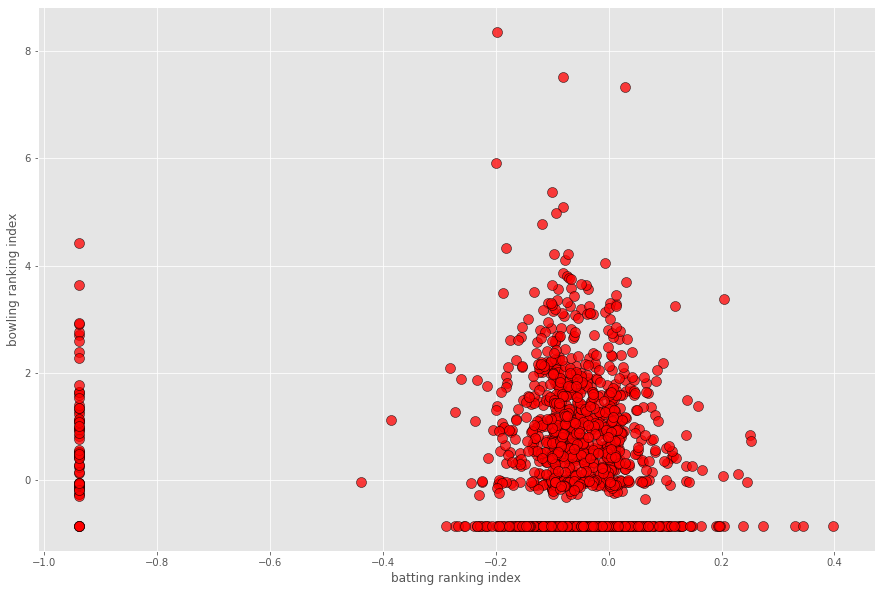

In [25]:
fig = plt.gcf()
fig.set_size_inches(15, 10)

plt.style.use('ggplot')
plt.scatter(aipIndexes.batRI, aipIndexes.bowlRI, s = 100, c = 'red', edgecolor = 'black', linewidth = .6, alpha = .75)
plt.xlabel('batting ranking index')
plt.ylabel('bowling ranking index')

plt.show()

### Applying K-Means Clustering with 5-neighbours on players indexes

In [26]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(aipIndexes[['batRI', 'bowlRI']])
aipIndexes['clusterRI'] = kmeans.predict(aipIndexes[['batRI', 'bowlRI']])

### Plotting Clustered Batting and Bowling indexes of all players

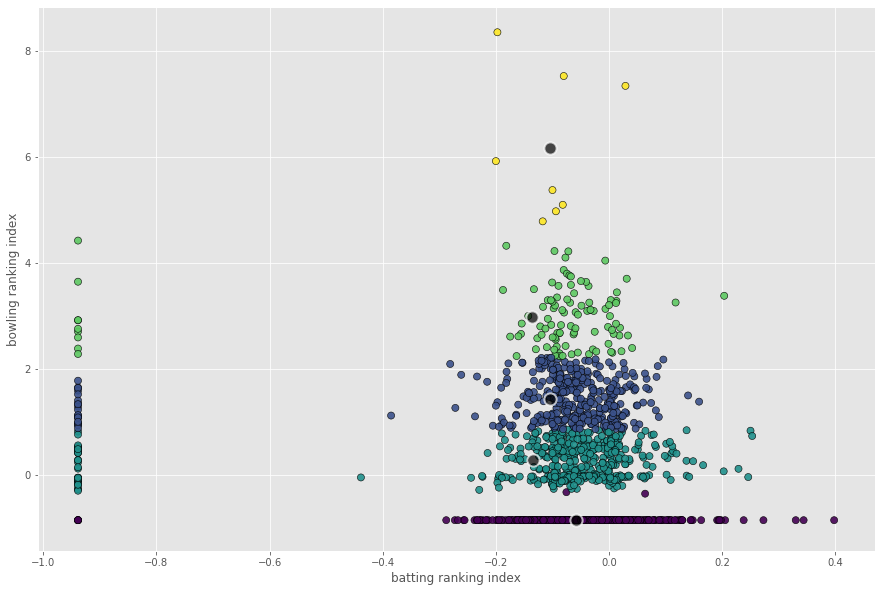

In [27]:
fig = plt.gcf()
fig.set_size_inches(15, 10)

plt.scatter(aipIndexes.batRI, aipIndexes.bowlRI, c = aipIndexes['clusterRI'] , s=50 ,edgecolor = 'black',
            linewidth = .6 ,alpha = .9)

plt.xlabel('batting ranking index')
plt.ylabel('bowling ranking index')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', edgecolor = 'white', linewidth = 2, s=150, alpha=.7);

plt.show()

### Displaying sample output of clustering

In [1]:
aipIndexes.head()
# aipIndexes.to_csv('tmpppp.csv')

NameError: name 'aipIndexes' is not defined

---

## 2.2 Cluster analysis for State Team Players

### Defining functions for index range manipulations

In [29]:
def weight_alpha(pindexes, a):
    
    x1 = pindexes['batRI'].values
    y1 = pindexes['bowlRI'].values
    for i in range(len(x1)):
        if(x1[i]>=0):
            x1[i]=x1[i]*(a/100)
        else:
            x1[i]=x1[i]+(x1[i]*((100-a)/100))
    for j in range(len(y1)):
        if(y1[j]>=0):
            y1[j]=y1[j]*(a/100)
        else:
            y1[j]=y1[j]+(y1[j]*((100-a)/100))
            

def modify(pindexes, mul):
    
    x1 = pindexes['batRI'].values
    y1 = pindexes['bowlRI'].values
    
    for i in range(len(x1)):
        x1[i]=x1[i]*mul
        y1[i]=y1[i]*mul


### Increasing range of indexes to thousand times

In [30]:
ctrain = aipIndexes.copy()
modify(ctrain, 1000)
ctrain.head()

,series_played,pid,batRI,bowlRI,clusterRI
0,15,3.0,82.813332,524.907844,2
1,1,6.0,-123.684211,349.038462,2
2,5,9.0,17.768635,573.215099,2
3,1,12.0,-938.530135,1647.188139,1
4,1,13.0,-938.530135,-74.397798,2


### Splitting data into input feature 'x' and output feature 'y'

In [31]:
x = ctrain.iloc[:,-3:-1].values
x = preprocessing.normalize(x)
x = preprocessing.scale(x)

y = ctrain.iloc[:,-1].values

### Applying KNN-Classifier taking 70% as training data

In [32]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

clf = KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree')
clf.fit(x_train,y_train)

print("Model Trained")

Model Trained


### Calculating accuracy of the model

In [33]:
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
print("Accuracy Score: ", acc3 * 100, "%")

Accuracy Score:  75.98039215686273 %


### Calculating ODI considerable performance of State Level players 

In [34]:
waspIndexes = aspIndexes.copy()
weight_alpha(waspIndexes, 6)

spred = waspIndexes.copy()
modify(spred,1000)
spred.head()  
# aspIndexes.head()

,series_played,pid,batRI,bowlRI
4,5,8198.0,21.238850,138.436673
5,3,10247.0,-241.153670,30.838329
6,3,8200.0,1.560818,-38.382052
8,3,10250.0,6.516590,23.337908
10,5,8204.0,12.003599,123.496062


### Looking for max index values

In [35]:
getMaxIndexes(waspIndexes, 5)

,MaxBatRI,MaxBowlRI
0,0.039765,0.388117
1,0.037236,0.377663
2,0.025357,0.370665
3,0.024908,0.360092
4,0.024225,0.357504


### Prepairing input for model

In [36]:
spredInp = spred[['batRI', 'bowlRI']].values
spredInp = preprocessing.normalize(spredInp)
spredInp = preprocessing.scale(spredInp)

### Predicting clusters for state level players

In [37]:
waspIndexes["clusterRI"] = clf.predict(spredInp)
waspIndexes.head()


,series_played,pid,batRI,bowlRI,clusterRI
4,5,8198.0,0.021239,0.138437,2
5,3,10247.0,-0.241154,0.030838,2
6,3,8200.0,0.001561,-0.038382,0
8,3,10250.0,0.006517,0.023338,2
10,5,8204.0,0.012004,0.123496,2


---

# 3. Team Structure Analysis

---

### Defining function to select state-wise top n players

In [38]:
def selStateWiseTopN(stateplayers, nbats, nbowls):
    sel = pd.DataFrame()
    
    sbt = stateplayers.sort_values(['team', 'batRI'], ascending = False).reset_index(drop = True)
    sbl = stateplayers.sort_values(['team', 'bowlRI'], ascending = False).reset_index(drop = True)
    
    for state in set(stateplayers.team):
        
        tsbt = sbt[sbt.team == state]
        
        sel = sel.append(tsbt.head(nbats), ignore_index=True)
            
        tsbl = sbl[sbl.team == state]
        sel = sel.append(tsbl.head(nbowls), ignore_index=True)
            
    sel = sel.drop_duplicates(subset='pid', keep='first', inplace=False)
    return sel


def selOverallTopN(stateplayers, nbats, nbowls):
    sel = pd.DataFrame()
    
    sbt = stateplayers.sort_values(['batRI', 'team'], ascending = False).reset_index(drop = True)
    sbl = stateplayers.sort_values(['bowlRI', 'team'], ascending = False).reset_index(drop = True)

    sel = sel.append(sbt.head(nbats), ignore_index=True)
    
    sel = sel.append(sbl.head(nbowls), ignore_index=True)
            
    sel = sel.drop_duplicates(subset='pid', keep='first', inplace=False)
    
    return sel


### Defining function to form final team

In [39]:
def selectPlayers(pclustered, team, nbats, nbowls, nall):
    pospl = pd.DataFrame()
    
    total_players = nbats + nbowls + nall
    rankbat = list()
    rankbowl = list()
    
    pteam = pclustered[pclustered.cid == team]
    
    lpteam = len(pteam)
    print("lpteam:", lpteam)
    
    if lpteam < total_players:
        print("ERROR: Avaliable players {} is less than required {}".format(lpteam, total_players))
        return None
    
    ptbat = pteam[(pteam.clusterRI == 0) | (pteam.clusterRI == 1)]
    ptbat = ptbat.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    lbat = len(ptbat)
#     print("bats: ", ptbat)
    
    ptbowl = pteam[pteam.clusterRI == 4]    
    ptbowl = ptbowl.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    lbowl = len(ptbowl)
#     print("ptbowls: ", ptbowl)
    
    ptall = pteam[(pteam.clusterRI == 2) | (pteam.clusterRI == 3)]
    ptall.insert(2, 'rir', ptall.batRI/ptall.bowlRI)
    lall = len(ptall)
#     print("ptall: ", ptall)
    
    if lbat < nbats:
        nall = nall + (nbats - lbat)
        nbats = lbat
        
    if lbowl < nbowls:
        nall = nall + (nbowls - lbowl)
        nbowls = lbowl
    
    if lall < nall:
        nbats = nbats + (nall - lall)
        nall = lall
        
#     mp = {
#         'batsman' : nbats,
#         'bowlers': nbowls,
#         'allrounders' : nall
#     }
#     print("Selecting: ", mp)
    
    ptall = ptall.sort_values(['rir', 'batRI','bowlRI'], ascending = False).reset_index(drop=True)
    
    for i in range(0, nbats):
        pospl = pospl.append(ptbat.iloc[i])
    

    for b in range(0, nbowls):
        pospl = pospl.append(ptbowl.iloc[b])
        
    l = len(pospl)
    for b in range(0, nall):
        pospl = pospl.append(ptall.iloc[b])
        
    print("tplayers: ", pospl.shape)
        
   #batting ranking

    batpl = pospl.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    
    
    for b in range(0, total_players):
        rankbat.append((b+1, [batpl.iloc[b]['name'], batpl.iloc[b]['team']]))
        
    #bowling ranking

    bowlpl = pospl.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    
    for b in range(0, total_players):
        rankbowl.append((b+1, [bowlpl.iloc[b]['name'], bowlpl.iloc[b]['team']]))
        
    return (rankbat, rankbowl)
        

### Importing players personal information

In [40]:
ipinfo = pd.read_csv('playerList.csv')
spinfo = pd.read_csv('newPlayerList.csv')

### Merging players personal info with their respective performance

In [41]:
iplayers = pd.DataFrame.merge(ipinfo, aipIndexes, on='pid', how='inner')
iplayers.insert(3, 'team', value='ODI')
iplayers.head()

,pid,name,yob,team,cid,iscurrent,series_played,batRI,bowlRI,clusterRI
0,2255,M N Samuels,1981,ODI,10,1,12,0.008107,0.953884,1
1,2977,H Masakadza,1983,ODI,11,1,9,-0.123575,0.117518,2
2,2995,Mashrafe Mortaza,1983,ODI,3,1,7,-0.089192,1.741568,1
3,3035,P A Patel,1985,ODI,5,1,7,-0.071118,-0.857488,0
4,3065,J M Anderson,1982,ODI,4,1,9,-0.006357,3.131126,3


In [42]:
splayers = pd.DataFrame.merge(spinfo, waspIndexes, on='pid', how='inner')
splayers.insert(4, 'cid', value=5)
splayers.tail()

,pid,name,yob,team,cid,iscurrent,series_played,batRI,bowlRI,clusterRI
394,13579,Ashutosh Aman,1998,Services,5,1,3,4.719212e-04,0.152884,1
395,13592,Trivendra Kumar,1998,Services,5,1,3,9.086980e-20,0.057964,1
396,13598,Fazil Rashid,1998,Jammu and Kashmir,5,1,3,-5.117454e-01,-1.547548,0
397,13599,Neelambuj Vats,1998,Tripura,5,1,3,-2.618624e-01,0.175072,1
398,13600,A Nagwaswalla,1998,Gujarat,5,1,3,3.178496e-04,0.126732,1


### Selecting top state level players based on criteria

In [43]:
tsplayers = selOverallTopN(splayers, 3, 2)
tsplayers.head(6)

,pid,name,yob,team,cid,iscurrent,series_played,batRI,bowlRI,clusterRI
0,1720,Abhinav Mukund,1998,Tamil Nadu,5,1,3,0.039765,-1.547548,0
1,145,Dinesh Karthik,1998,Tamil Nadu,5,1,3,0.037236,-1.547548,0
2,11813,Ruturaj Gaikwad,1998,Maharashtra,5,1,4,0.025357,-1.547548,0
3,8918,Kushang Patel,1998,Saurashtra,5,1,3,-0.436224,0.388117,2
4,1828,Siddarth Kaul,1998,Punjab,5,1,5,0.002500,0.377663,1


### Merging both players data together to form dataset of all players

In [44]:
aplayers = iplayers.append(tsplayers, sort=True).reset_index(drop=True)
aplayers.head(5)

,batRI,bowlRI,cid,clusterRI,iscurrent,name,pid,series_played,team,yob
0,0.008107,0.953884,10,1,1,M N Samuels,2255,12,ODI,1981
1,-0.123575,0.117518,11,2,1,H Masakadza,2977,9,ODI,1983
2,-0.089192,1.741568,3,1,1,Mashrafe Mortaza,2995,7,ODI,1983
3,-0.071118,-0.857488,5,0,1,P A Patel,3035,7,ODI,1985
4,-0.006357,3.131126,4,3,1,J M Anderson,3065,9,ODI,1982


### Extracting players of a country (INDIA)

In [45]:
for_country = 5
caplayers = aplayers[aplayers['cid']  == for_country]

### Selection of players

In [46]:
ranking = selectPlayers(aplayers, team=5, nbats = 5, nbowls = 4, nall = 2)

if ranking is not None:
    print('BATSMAN RANKING')
    print('----------------------------------------------------')
    for pl in ranking[0]:
        print('POSITION: ', "{:>2}: ".format(pl[0]), "{:<20}".format(pl[1][0]), "{:>10}".format("team: "), pl[1][1])

    print()
    print('BOWLER RANKING') 
    print('----------------------------------------------------')
    for pl in ranking[1]:
        print('POSITION: ', "{:>2}: ".format(pl[0]), "{:<20}".format(pl[1][0]), "{:>10}".format("team: "), pl[1][1])
  

lpteam: 52
tplayers:  (11, 11)
BATSMAN RANKING
----------------------------------------------------
POSITION:   1:  V Kohli                  team:  ODI
POSITION:   2:  A T Rayudu               team:  ODI
POSITION:   3:  M S Dhoni                team:  ODI
POSITION:   4:  R G Sharma               team:  ODI
POSITION:   5:  D S Kulkarni             team:  ODI
POSITION:   6:  Abhinav Mukund           team:  Tamil Nadu
POSITION:   7:  Dinesh Karthik           team:  Tamil Nadu
POSITION:   8:  K L Rahul                team:  ODI
POSITION:   9:  S Dube                   team:  ODI
POSITION:  10:  S Kaul                   team:  ODI
POSITION:  11:  Mohammed Siraj           team:  ODI

BOWLER RANKING
----------------------------------------------------
POSITION:   1:  D S Kulkarni             team:  ODI
POSITION:   2:  A T Rayudu               team:  ODI
POSITION:   3:  R G Sharma               team:  ODI
POSITION:   4:  V Kohli                  team:  ODI
POSITION:   5:  S Dube               